# ODAPT

## 1. Transcriptomic Analysis + Drug Reversal Scoring

### a. Data set download

The project started by downloading the GEO dataset GSE83148, which contains transcriptomic expression data for 128 samples: 122 infected and 6 controls. After importing all necessary libraries for data manipulation, statistics, visualization, and cheminformatics, the raw expression data was loaded and inspected.

Setting the enviorment

In [1]:
!pip install pandas numpy matplotlib seaborn GEOparse

In [2]:
!pip install tqdm useful_rdkit_utils seaborn scikit-posthocs chembl_downloader chembl_webresource_client pubchempy

In [3]:
!pip install cmapPy

In [4]:
!pip install scikit-posthocs

In [5]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 33.6 MB/s eta 0:00:00


In [52]:
# Data manipulation and numerical computing
import pandas as pd
import numpy as np
import os

# Statistics and data preprocessing
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# GEO data parsing
import GEOparse
from cmapPy.pandasGEXpress.parse import parse

# RDKit for cheminformatics
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import FilterCatalog
from rdkit.Chem.FilterCatalog import FilterCatalogParams
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity

# ChEMBL web resource client
from chembl_webresource_client.new_client import new_client


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
gse = GEOparse.get_GEO(geo="GSE83148", destdir="./")

25-Jul-2025 18:14:36 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
25-Jul-2025 18:14:36 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
25-Jul-2025 18:14:36 INFO GEOparse - Parsing ./GSE83148_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE83148_family.soft.gz: 
25-Jul-2025 18:14:36 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
25-Jul-2025 18:14:36 DEBUG GEOparse - SERIES: GSE83148
DEBUG:GEOparse:SERIES: GSE83148
25-Jul-2025 18:14:36 DEBUG GEOparse - PLATFORM: GPL570
DEBUG:GEOparse:PLATFORM: GPL570
/usr/local/lib/python3.11/dist-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
25-Jul-2025 18:14:38 DEBUG GEOparse - SAMPLE: GSM2195416
DEBUG:GEOparse:SAMPLE: GSM2195416
25-Jul-2025 18:14:38 DEBUG GEOpars

In [11]:
# Visualize in a data frame
df_gse = gse.pivot_samples('VALUE')
df_gse

name,GSM2195416,GSM2195417,GSM2195418,GSM2195419,GSM2195420,GSM2195421,GSM2195422,GSM2195423,GSM2195424,GSM2195425,...,GSM2195534,GSM2195535,GSM2195536,GSM2195537,GSM2291960,GSM2291961,GSM2291962,GSM2291963,GSM2291964,GSM2291965
ID_REF,,,,,,,,,,,,,,,,,,,,,
1007_s_at,7.87550,6.80810,7.01067,6.87384,6.91454,7.14768,7.05695,7.40349,7.33204,7.43099,...,6.43570,7.32376,7.25377,6.91295,6.37363,6.49795,6.43963,6.36531,6.41111,6.76942
1053_at,6.29315,5.79981,6.66245,5.83645,5.81384,6.11788,5.99030,5.88610,6.13099,6.12643,...,6.57556,5.89270,6.56900,6.02517,6.07680,6.05225,6.24640,5.96225,6.17774,6.13837
117_at,4.72855,4.83994,5.08763,5.03321,4.92007,4.51137,4.87317,4.71532,4.92108,4.67567,...,5.01273,5.06820,5.05112,5.33136,4.52563,4.41339,4.69457,4.39229,4.90550,4.48230
121_at,6.96665,6.67761,7.30685,7.64177,7.28214,6.85364,7.11758,7.19491,6.93070,7.14518,...,7.05218,8.31497,6.90509,7.23741,6.72771,6.92092,6.43475,6.69107,6.66813,6.67931
1255_g_at,1.85751,1.72451,2.09563,1.82042,1.89416,1.96510,1.98721,2.01883,2.19108,2.25712,...,2.21792,2.12660,1.82771,1.99025,1.65623,1.87992,1.89249,1.72565,1.69217,1.68314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AFFX-r2-Ec-bioC-5_at,8.02208,9.78277,9.96045,10.61390,9.03569,9.05317,9.37279,9.27172,9.45382,9.29574,...,10.17320,11.25930,9.82280,9.72706,9.69447,9.61688,9.74083,9.62794,9.73554,9.86623
AFFX-r2-Ec-bioD-3_at,10.52260,11.95700,11.63290,12.68420,11.48890,11.33360,11.56720,11.58910,11.72650,11.54470,...,12.34520,13.08950,12.45990,12.42100,12.04100,11.92310,11.98480,11.89110,12.02050,12.07160
AFFX-r2-Ec-bioD-5_at,9.52292,11.14590,10.45660,11.85640,10.42180,10.42260,10.62210,10.56370,10.71260,10.52320,...,11.43940,12.39110,11.60060,11.51200,11.29570,11.20720,11.24160,11.09040,11.24860,11.31790


### b. Gene Groupby

To consolidate probe-level expression data into gene-level, the annotation file for the microarray platform (GPL570) was used. Probes were grouped by their corresponding gene symbols, and their expression values were averaged. This step was crucial to reduce redundancy and ensure the analysis focused on biologically relevant gene-level signals.


In [12]:
path = '/content/drive/MyDrive/Colab Notebooks/Project'
os.chdir(path)

In [13]:
# Probe --> Gene
anot = pd.read_csv("GPL570-55999.txt", sep="\t", dtype=str, comment='#')

In [14]:
anot

,ID,GB_ACC,SPOT_ID,Species Scientific Name,Annotation Date,Sequence Type,Sequence Source,Target Description,Representative Public ID,Gene Title,Gene Symbol,ENTREZ_GENE_ID,RefSeq Transcript ID,Gene Ontology Biological Process,Gene Ontology Cellular Component,Gene Ontology Molecular Function
0,1007_s_at,U48705,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,Affymetrix Proprietary Database,U48705 /FEATURE=mRNA /DEFINITION=HSU48705 Huma...,U48705,discoidin domain receptor tyrosine kinase 1 //...,DDR1 /// MIR4640,780 /// 100616237,NM_001202521 /// NM_001202522 /// NM_001202523...,0001558 // regulation of cell growth // inferr...,0005576 // extracellular region // inferred fr...,0000166 // nucleotide binding // inferred from...
1,1053_at,M87338,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,GenBank,M87338 /FEATURE= /DEFINITION=HUMA1SBU Human re...,M87338,"replication factor C (activator 1) 2, 40kDa",RFC2,5982,NM_001278791 /// NM_001278792 /// NM_001278793...,0000278 // mitotic cell cycle // traceable aut...,0005634 // nucleus // inferred from electronic...,0000166 // nucleotide binding // inferred from...
2,117_at,X51757,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,Affymetrix Proprietary Database,X51757 /FEATURE=cds /DEFINITION=HSP70B Human h...,X51757,heat shock 70kDa protein 6 (HSP70B'),HSPA6,3310,NM_002155,0000902 // cell morphogenesis // inferred from...,0005737 // cytoplasm // inferred from direct a...,0000166 // nucleotide binding // inferred from...
3,121_at,X69699,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,GenBank,X69699 /FEATURE= /DEFINITION=HSPAX8A H.sapiens...,X69699,paired box 8,PAX8,7849,NM_003466 /// NM_013951 /// NM_013952 /// NM_0...,0001655 // urogenital system development // in...,0005634 // nucleus // inferred from direct ass...,0000979 // RNA polymerase II core promoter seq...
4,1255_g_at,L36861,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,Affymetrix Proprietary Database,L36861 /FEATURE=expanded_cds /DEFINITION=HUMGC...,L36861,guanylate cyclase activator 1A (retina),GUCA1A,2978,NM_000409 /// XM_006715073,0007165 // signal transduction // non-traceabl...,0001750 // photoreceptor outer segment // infe...,0005509 // calcium ion binding // inferred fro...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54670,AFFX-ThrX-5_at,NaN,--Control,Homo sapiens,"Oct 6, 2014",Control sequence,Affymetrix Proprietary Database,B. subtilis /GEN=thrC /DB_XREF=gb:X04603.1 /NO...,AFFX-ThrX-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54671,AFFX-ThrX-M_at,NaN,--Control,Homo sapiens,"Oct 6, 2014",Control sequence,Affymetrix Proprietary Database,"B. subtilis /GEN=thrC, thrB /DB_XREF=gb:X04603...",AFFX-ThrX-M,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54672,AFFX-TrpnX-3_at,NaN,--Control,Homo sapiens,"Oct 6, 2014",Control sequence,Affymetrix Proprietary Database,"B. subtilis /GEN=trpC, trpF /DB_XREF=gb:K01391...",AFFX-TrpnX-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54673,AFFX-TrpnX-5_at,NaN,--Control,Homo sapiens,"Oct 6, 2014",Control sequence,Affymetrix Proprietary Database,"B. subtilis /GEN=trpE, trpD /DB_XREF=gb:K01391...",AFFX-TrpnX-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
anot.columns = anot.columns.str.strip()

In [16]:
df_gse.columns = df_gse.columns.str.strip()
# Drop Dulicates
if 'ID_REF\t' in df_gse.columns:
    df_gse = df_gse.drop(columns=['ID_REF\t'])

if 'ID_REF' in df_gse.columns:
    df_gse = df_gse.drop.duplicated(columns=['ID_REF'])

df_gse = df_gse.loc[:, ~df_gse.columns.duplicated()]

In [17]:
anot_indexed = anot.set_index('ID')
df_gse_2 = df_gse.merge(anot_indexed[['Gene Symbol']], left_index=True, right_index=True, how='left')

In [18]:
df_gse_2

,GSM2195416,GSM2195417,GSM2195418,GSM2195419,GSM2195420,GSM2195421,GSM2195422,GSM2195423,GSM2195424,GSM2195425,...,GSM2195535,GSM2195536,GSM2195537,GSM2291960,GSM2291961,GSM2291962,GSM2291963,GSM2291964,GSM2291965,Gene Symbol
ID_REF,,,,,,,,,,,,,,,,,,,,,
1007_s_at,7.87550,6.80810,7.01067,6.87384,6.91454,7.14768,7.05695,7.40349,7.33204,7.43099,...,7.32376,7.25377,6.91295,6.37363,6.49795,6.43963,6.36531,6.41111,6.76942,DDR1 /// MIR4640
1053_at,6.29315,5.79981,6.66245,5.83645,5.81384,6.11788,5.99030,5.88610,6.13099,6.12643,...,5.89270,6.56900,6.02517,6.07680,6.05225,6.24640,5.96225,6.17774,6.13837,RFC2
117_at,4.72855,4.83994,5.08763,5.03321,4.92007,4.51137,4.87317,4.71532,4.92108,4.67567,...,5.06820,5.05112,5.33136,4.52563,4.41339,4.69457,4.39229,4.90550,4.48230,HSPA6
121_at,6.96665,6.67761,7.30685,7.64177,7.28214,6.85364,7.11758,7.19491,6.93070,7.14518,...,8.31497,6.90509,7.23741,6.72771,6.92092,6.43475,6.69107,6.66813,6.67931,PAX8
1255_g_at,1.85751,1.72451,2.09563,1.82042,1.89416,1.96510,1.98721,2.01883,2.19108,2.25712,...,2.12660,1.82771,1.99025,1.65623,1.87992,1.89249,1.72565,1.69217,1.68314,GUCA1A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AFFX-r2-Ec-bioC-5_at,8.02208,9.78277,9.96045,10.61390,9.03569,9.05317,9.37279,9.27172,9.45382,9.29574,...,11.25930,9.82280,9.72706,9.69447,9.61688,9.74083,9.62794,9.73554,9.86623,NaN
AFFX-r2-Ec-bioD-3_at,10.52260,11.95700,11.63290,12.68420,11.48890,11.33360,11.56720,11.58910,11.72650,11.54470,...,13.08950,12.45990,12.42100,12.04100,11.92310,11.98480,11.89110,12.02050,12.07160,NaN
AFFX-r2-Ec-bioD-5_at,9.52292,11.14590,10.45660,11.85640,10.42180,10.42260,10.62210,10.56370,10.71260,10.52320,...,12.39110,11.60060,11.51200,11.29570,11.20720,11.24160,11.09040,11.24860,11.31790,NaN


In [19]:
df_gse_gen = df_gse_2.groupby('Gene Symbol').mean()

In [20]:
df_gse_gen

,GSM2195416,GSM2195417,GSM2195418,GSM2195419,GSM2195420,GSM2195421,GSM2195422,GSM2195423,GSM2195424,GSM2195425,...,GSM2195534,GSM2195535,GSM2195536,GSM2195537,GSM2291960,GSM2291961,GSM2291962,GSM2291963,GSM2291964,GSM2291965
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,11.63750,12.160500,12.691400,12.553900,11.871800,11.58390,11.808100,11.504100,11.701300,11.809800,...,12.557400,11.833200,12.528500,12.632300,12.24190,12.322200,12.451700,12.452700,12.481400,12.43490
A1BG-AS1,3.78837,4.939100,4.043060,4.443840,3.905350,3.49460,3.845120,3.583990,3.594870,3.681890,...,4.388870,4.223270,4.410480,4.337600,4.24141,3.819080,3.912930,4.122000,3.885510,3.93615
A1CF,9.69360,9.972655,10.037105,10.184980,9.963775,9.68156,9.984255,9.751525,9.782985,9.907275,...,9.477005,8.625375,10.194825,10.374590,10.78025,10.436875,10.345575,10.521105,10.814650,10.81170
A2M,8.52523,8.200570,7.979665,8.833445,9.003965,8.38389,8.283265,8.443475,8.420625,8.459235,...,8.232885,7.914230,8.668230,8.688415,7.59560,8.044635,7.745155,8.152985,8.262555,8.14561
A2M-AS1,5.29198,5.731150,3.603800,5.671440,4.483800,4.80784,4.841190,4.798840,5.206340,5.244880,...,5.485170,4.371190,5.836250,5.719630,4.30102,4.200840,3.998950,4.192130,4.946260,4.89772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
abParts /// IGKC /// IGKV4-1 /// IGKV4-1,6.61839,8.031790,5.516260,5.987310,6.025760,6.37078,5.497230,6.155720,5.970830,7.345660,...,6.809260,6.024400,6.150150,6.474020,5.48680,5.693700,5.220010,5.510910,5.584790,5.61872
av27s1 /// TRAV39 /// TRAV39,3.72498,3.580880,3.668600,4.022930,4.277550,3.54976,3.660580,3.700430,3.968690,4.219890,...,3.635200,4.133110,3.935580,3.658320,3.46797,3.358950,3.449570,3.258850,3.144790,3.22077
hsa-let-7a-3 /// hsa-let-7b /// hsa-mir-4763 /// MIRLET7BHG /// RP4-695O20__B.10,4.66262,4.702640,4.685850,4.852920,4.822370,4.60510,4.671240,4.705920,5.057010,4.422130,...,4.584920,5.329470,4.168000,4.750530,4.62864,4.478790,4.125250,4.544360,4.599700,3.94367


### c. Label samples and normalizing

During preprocessing, no additional normalization was applied to the expression matrix. Although normalization (e.g., log transformation or scaling) was initially considered, it led to inconsistent results during differential gene expression (DEG) analysis.

A closer inspection of the original expression values in the GSE83148 dataset showed that intensities ranged approximately between 1 and 15, which is consistent with data that has already been log2-normalized — a common practice in transcriptomic datasets deposited in GEO.

Further investigation into GEO documentation and related publications confirmed that many datasets, especially those using microarray platforms such as GPL570, are already normalized by the original submitting group. Based on this, the decision was made to proceed using the raw values as downloaded, avoiding unnecessary distortions when comparing experimental conditions.

In [21]:
for name, gsm in gse.gsms.items():
    print(name, gsm.metadata["title"])

GSM2195416 ['Human_HBV_sample_Hep-0002']
GSM2195417 ['Human_HBV_sample_Hep-0003']
GSM2195418 ['Human_HBV_sample_Hep-0004']
GSM2195419 ['Human_HBV_sample_Hep-0006']
GSM2195420 ['Human_HBV_sample_Hep-0007']
GSM2195421 ['Human_HBV_sample_Hep-0024']
GSM2195422 ['Human_HBV_sample_Hep-0025']
GSM2195423 ['Human_HBV_sample_Hep-0026']
GSM2195424 ['Human_HBV_sample_Hep-0030']
GSM2195425 ['Human_HBV_sample_Hep-0031']
GSM2195426 ['Human_HBV_sample_Hep-0032']
GSM2195427 ['Human_HBV_sample_Hep-0036']
GSM2195428 ['Human_HBV_sample_Hep-0039']
GSM2195429 ['Human_HBV_sample_Hep-0040']
GSM2195430 ['Human_HBV_sample_Hep-0059']
GSM2195431 ['Human_HBV_sample_Hep-0061']
GSM2195432 ['Human_HBV_sample_Hep-0067']
GSM2195433 ['Human_HBV_sample_Hep-0068']
GSM2195434 ['Human_HBV_sample_Hep-0069']
GSM2195435 ['Human_HBV_sample_Hep-0071']
GSM2195436 ['Human_HBV_sample_Hep-0072']
GSM2195437 ['Human_HBV_sample_Hep-0073']
GSM2195438 ['Human_HBV_sample_Hep-0074']
GSM2195439 ['Human_HBV_sample_Hep-0075']
GSM2195440 ['Hum

In [22]:
sample_labels = {}
for name, gsm in gse.gsms.items():
    title = gsm.metadata['title'][0].lower()
    if 'normal' in title:
        sample_labels[name] = 'control'
    elif 'hbv' in title:
        sample_labels[name] = 'infected'

In [23]:
labels = pd.Series(sample_labels)

In [24]:
labels

,0
GSM2195416,infected
GSM2195417,infected
GSM2195418,infected
GSM2195419,infected
GSM2195420,infected
...,...
GSM2291961,control
GSM2291962,control
GSM2291963,control
GSM2291964,control


In [25]:
labels.value_counts()

,count
infected,122
control,6


In [26]:
control_samples = labels[labels == 'control'].index.tolist()
infected_samples = labels[labels == 'infected'].index.tolist()

### d. Differencial Gene Expression (DEGs)

Using statistical testing, expression differences between infected and control samples were evaluated for each gene. Log2 fold change (log2FC) was calculated alongside p-values, which were adjusted for multiple hypothesis testing using FDR correction.

Given the relatively low log2FC values observed, thresholds were adjusted to a more sensitive cutoff of ±0.2 instead of the conventional ±1. This enabled capturing subtle but potentially meaningful transcriptional changes. The resulting volcano plot visualized significance versus fold change, highlighting more up-regulated genes than down-regulated ones.

From the significant genes, the top 50 up- and down-regulated genes were selected to create gene signatures for downstream analyses.

In [27]:
# Using scipy stats
results = []

for gene in df_gse_gen.index:
    control_vals = df_gse_gen.loc[gene, control_samples].dropna()
    infected_vals = df_gse_gen.loc[gene, infected_samples].dropna()
    # t-test
    stat, pvalue = ttest_ind(control_vals, infected_vals, equal_var=False)
    #Log2fc
    mean_control = control_vals.mean()
    mean_infected = infected_vals.mean()
    log2fc = np.log2(mean_infected + 1e-9) - np.log2(mean_control + 1e-9)

    results.append({'gene': gene, 'pvalue': pvalue, 'log2FC': log2fc})


results_df = pd.DataFrame(results)
results_df['padj'] = multipletests(results_df['pvalue'], method='fdr_bh')[1]

In [28]:
results_df

,gene,pvalue,log2FC,padj
0,A1BG,4.950089e-04,-0.027068,1.661331e-03
1,A1BG-AS1,1.393989e-01,0.043581,1.757147e-01
2,A1CF,5.983962e-05,-0.105939,3.389759e-04
3,A2M,6.707159e-03,0.081679,1.290514e-02
4,A2M-AS1,2.651741e-03,0.254604,6.080030e-03
...,...,...,...,...
23515,abParts /// IGKC /// IGKV4-1 /// IGKV4-1,5.533298e-13,0.289240,6.442731e-11
23516,av27s1 /// TRAV39 /// TRAV39,1.430330e-04,0.191104,6.462035e-04
23517,hsa-let-7a-3 /// hsa-let-7b /// hsa-mir-4763 /...,4.944193e-02,0.094757,7.050286e-02
23518,hsa-let-7a-3 /// hsa-let-7b /// hsa-mir-4763 /...,8.088316e-03,0.157431,1.507785e-02


In [29]:
# Filtering
sig = results_df[results_df['padj'] <= 0.05]
up_genes = sig[sig['log2FC'] > 0.3].sort_values('log2FC', ascending=False).head(50)
down_genes = sig[sig['log2FC'] < -0.2].sort_values('log2FC').head(50)

gene_signature_df = pd.DataFrame({
    'Up_regulated': up_genes['gene'].reset_index(drop=True),
    'Down_regulated': down_genes['gene'].reset_index(drop=True)
})

gene_signature_df

,Up_regulated,Down_regulated
0,CXCL11,GLYATL1
1,MIR155 /// MIR155HG,KNCN
2,CD69,GPR88
3,XIST,LOC101929910 /// LOC613037 /// NPIPA5 /// NPIP...
4,PBK,GPR37
5,CXCL6,C5orf27
6,EGR2,FAM224A /// FAM224B
7,CCL20,NCAM2
8,RRM2,CTAGE5 /// MIA2
9,GABBR1 /// UBD,LOC100129917


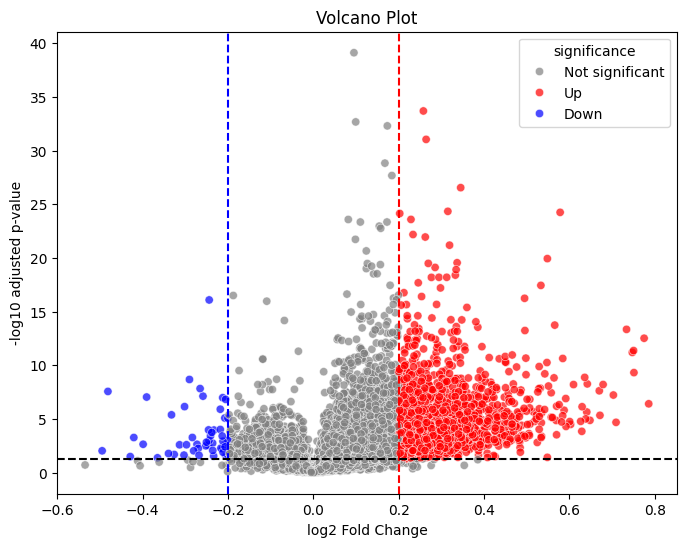

In [30]:
#Volcano plot
results_df['significance'] = 'Not significant'
results_df.loc[(results_df['padj'] < 0.05) & (results_df['log2FC'] > 0.2), 'significance'] = 'Up'
results_df.loc[(results_df['padj'] < 0.05) & (results_df['log2FC'] < -0.2), 'significance'] = 'Down'

plt.figure(figsize=(8,6))
sns.scatterplot(data=results_df, x='log2FC', y=-np.log10(results_df['padj']),
                hue='significance', palette={'Up': 'red', 'Down': 'blue', 'Not significant': 'grey'},
                alpha=0.7)
plt.axvline(0.2, color='red', linestyle='--')
plt.axvline(-0.2, color='blue', linestyle='--')
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10 adjusted p-value")
plt.title("Volcano Plot")
plt.show()


In [31]:
gene_signature_df.to_csv('top_50.csv', index=False)

In [32]:
results_df.set_index("gene", inplace=True)
results_df

,pvalue,log2FC,padj,significance
gene,,,,
A1BG,4.950089e-04,-0.027068,1.661331e-03,Not significant
A1BG-AS1,1.393989e-01,0.043581,1.757147e-01,Not significant
A1CF,5.983962e-05,-0.105939,3.389759e-04,Not significant
A2M,6.707159e-03,0.081679,1.290514e-02,Not significant
A2M-AS1,2.651741e-03,0.254604,6.080030e-03,Up
...,...,...,...,...
abParts /// IGKC /// IGKV4-1 /// IGKV4-1,5.533298e-13,0.289240,6.442731e-11,Up
av27s1 /// TRAV39 /// TRAV39,1.430330e-04,0.191104,6.462035e-04,Not significant
hsa-let-7a-3 /// hsa-let-7b /// hsa-mir-4763 /// MIRLET7BHG /// RP4-695O20__B.10,4.944193e-02,0.094757,7.050286e-02,Not significant


To visually assess the differential expression patterns across samples, a heatmap was generated based on the top differentially expressed genes. Genes were selected according to adjusted p-value and log2 fold-change thresholds, and expression values were z-score standardized per gene to emphasize relative expression across conditions.

Clustering was applied both by gene and by sample using Euclidean distance and average linkage, allowing us to identify consistent gene regulation patterns distinguishing healthy versus infected liver samples.

In [33]:
degs = results_df[(results_df['pvalue'] < 0.05) & (abs(results_df['log2FC']) > 0.1)].index.tolist()

In [34]:
matriz_degs = df_gse_gen.loc[degs]

In [35]:
matriz_normalized = df_gse_gen.sub(df_gse_gen.mean(axis=1), axis=0)
matriz_normalized = matriz_normalized.div(df_gse_gen.std(axis=1), axis=0)

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


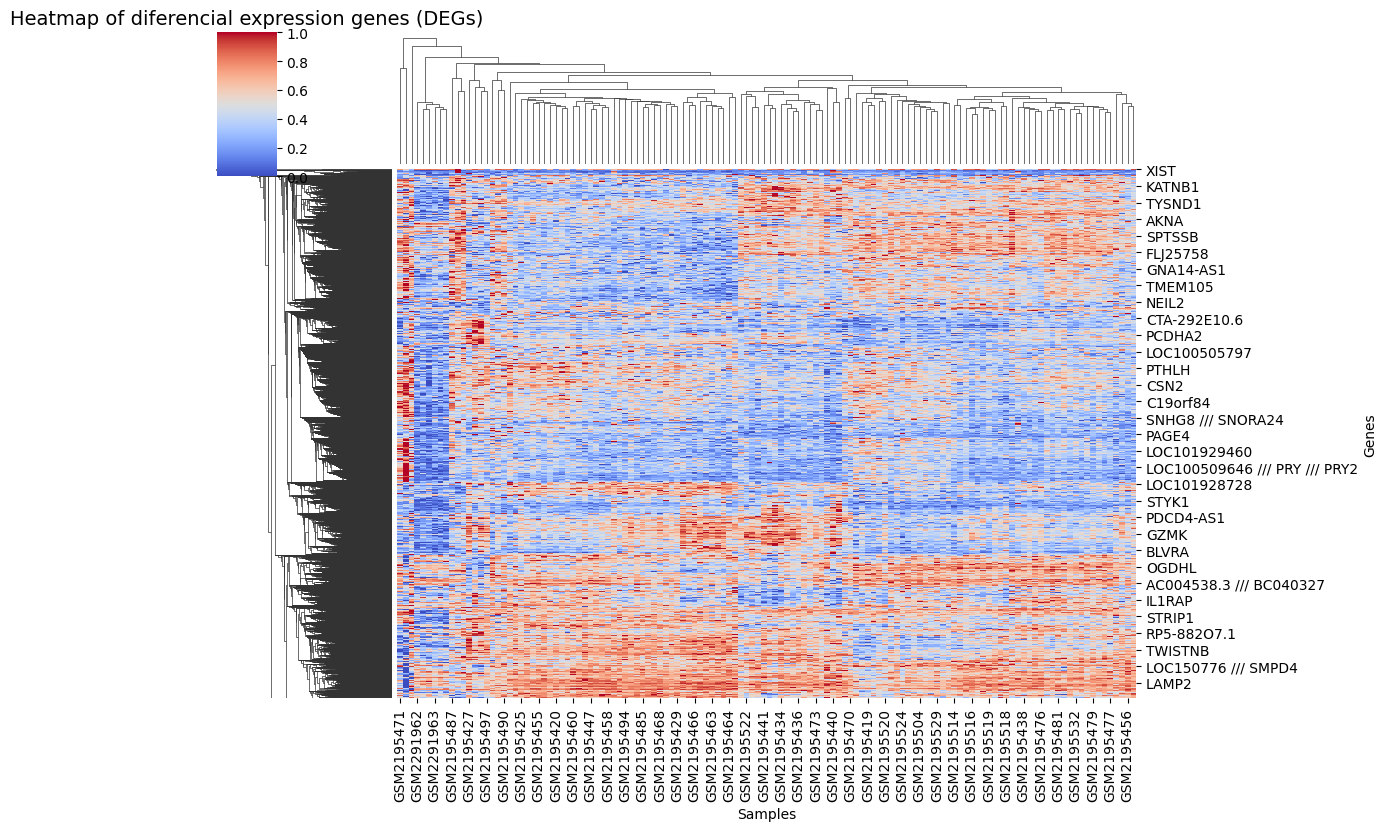

In [36]:
g= sns.clustermap(matriz_normalized,cmap='coolwarm', standard_scale=0, figsize=(12, 8), col_cluster=True)
plt.title('Heatmap of diferencial expression genes (DEGs)', fontsize=14)
g.ax_heatmap.set_xlabel('Samples')
g.ax_heatmap.set_ylabel('Genes')
plt.savefig('heatmap_DEGs.png', dpi=300, bbox_inches='tight')
plt.show()

The heatmap shows hierarchical clustering both across genes and across samples, helping to identify patterns of co-expression and similarity between biological conditions.
Sample pattern observation:
The upper and lower sections of the heatmap show groups of genes that are consistently co-expressed within specific samples. Notably:

Genes in the bottom region (e.g., LAMP2, SMPD4) show consistently higher expression in a subset of samples, likely representing infected or altered conditions.Genes in the top region appear co-repressed across similar groups. The middle region is more heterogeneous, reflecting variable expression patterns or genes that do not clearly separate between groups.

This visualization suggests distinct expression signatures between sample clusters, potentially corresponding to disease status (e.g., infected vs. control). It supports the biological relevance of the selected DEGs and helps in downstream interpretation or drug prioritization.

### e. Drug Reversal Scoring

The gene signatures were submitted to the CLUE.io platform for connectivity mapping to identify perturbagens that reverse or mimic the infection signature. However, a limitation was that several genes from the dataset did not map correctly in CLUE.io, potentially reducing the sensitivity and coverage of the analysis.

In [37]:
gctx_file = "ncs2.gctx"
gctoo = parse(gctx_file)

/usr/local/lib/python3.11/dist-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
/usr/local/lib/python3.11/dist-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))


In [38]:
df = gctoo.data_df
df

cid,TAG
rid,
ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:0.3125:24,-1.074787
ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:0.3125:3,0.000000
ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:0.625:24,-0.742436
ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:0.625:3,0.000000
ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:1.25:24,0.000000
...,...
ZTO.XPR001_THP1_408H:GC1:-666,0.000000
ZTO.XPR001_THP1_408H:GC2:-666,0.000000
ZTO.XPR001_U937_408H:CMAP-000:-666,0.000000


In [39]:
df_sorted = df.sort_values(by="TAG", ascending=True)
df_sorted.head(10)

cid,TAG
rid,
LJP006_LNCAP_24H:L15,-1.979779
CPC008_VCAP_24H:BRD-A30612536-001-01-4:10,-1.939298
CPC017_HEPG2_6H:BRD-K17743697-066-02-8:10,-1.929829
REP.A026_A549_24H:P21,-1.921190
REP.A015_MCF7_24H:F20,-1.918949
KDC006_PC3_96H:TRCN0000006082:-666,-1.912017
KDD003_VCAP_120H:TRCN0000036422:-666,-1.903741
CPC019_PC3_24H:J23,-1.896890
CPC006_PC3_6H:BRD-K01638814-051-10-1:10,-1.893808


In [40]:
df_sorted = df_sorted.reset_index()

In [41]:
df_sorted['compound'] = df_sorted['rid'].apply(lambda x: x.split(":")[1] if isinstance(x, str) else x)

In [42]:
df_finals = df_sorted[['compound', 'TAG']]
df_finals

cid,compound,TAG
0,L15,-1.979779
1,BRD-A30612536-001-01-4,-1.939298
2,BRD-K17743697-066-02-8,-1.929829
3,P21,-1.921190
4,F20,-1.918949
...,...,...
1165461,G21,1.913568
1165462,C10,1.913862
1165463,B16,1.918723
1165464,F18,1.923410


The connectivity map results, which included normalized connectivity scores linked to various drugs, were merged with metadata to annotate perturbations.

In [43]:
compound_info = pd.read_csv('cluesignatures.txt', sep='\t')

In [44]:
compound_info

,MoA,cmap_name,inchi_key,pert_id,target
0,CAR agonist,meclizine,OCJYIGYOJCODJL-UHFFFAOYSA-N,BRD-A50311610,NR1I3
1,CAR agonist,TCPOBOP,BAFKRPOFIYPKBQ-UHFFFAOYSA-N,BRD-K30743633,NR1I3
2,ALK inhibitor,DMH1,JMIFGARJSWXZSH-UHFFFAOYSA-N,BRD-K39381259,ACVR1
3,Akt inhibitor,GDC-0068,GRZXWCHAXNAUHY-NSISKUIASA-N,BRD-K43002773,AKT3
4,Akt inhibitor,GDC-0068,GRZXWCHAXNAUHY-NSISKUIASA-N,BRD-K43002773,AKT1
...,...,...,...,...,...
995,EGFR inhibitor,butein,AYMYWHCQALZEGT-ORCRQEGFSA-N,BRD-K17497770,ACE
996,EGFR inhibitor,canertinib,OMZCMEYTWSXEPZ-UHFFFAOYSA-N,BRD-K50168500,EGFR
997,EGFR inhibitor,canertinib,OMZCMEYTWSXEPZ-UHFFFAOYSA-N,BRD-K50168500,ERBB2
998,EGFR inhibitor,canertinib,OMZCMEYTWSXEPZ-UHFFFAOYSA-N,BRD-K50168500,ERBB4


In [45]:
df_merged2 = df_finals.merge(compound_info, left_on='compound', right_on='pert_id', how='inner')

In [46]:
top_50= df_merged2.sort_values(by='TAG', ascending=True)
top_50 = top_50.head(50).reset_index(drop=True)
top_50

,compound,TAG,MoA,cmap_name,inchi_key,pert_id,target
0,BRD-K08109215,-1.868729,Bromodomain inhibitor,I-BET-762,AAAQFGUYHFJNHI-SFHVURJKSA-N,BRD-K08109215,BRD4
1,BRD-K08109215,-1.868729,Bromodomain inhibitor,I-BET-762,AAAQFGUYHFJNHI-SFHVURJKSA-N,BRD-K08109215,BRD3
2,BRD-K08109215,-1.868729,Bromodomain inhibitor,I-BET-762,AAAQFGUYHFJNHI-SFHVURJKSA-N,BRD-K08109215,BRD2
3,BRD-A19500257,-1.762455,HSP inhibitor,geldanamycin,QTQAWLPCGQOSGP-VDYWNIEOSA-N,BRD-A19500257,HSP90AA1
4,BRD-K08109215,-1.685802,Bromodomain inhibitor,I-BET-762,AAAQFGUYHFJNHI-SFHVURJKSA-N,BRD-K08109215,BRD4
5,BRD-K08109215,-1.685802,Bromodomain inhibitor,I-BET-762,AAAQFGUYHFJNHI-SFHVURJKSA-N,BRD-K08109215,BRD2
6,BRD-K08109215,-1.685802,Bromodomain inhibitor,I-BET-762,AAAQFGUYHFJNHI-SFHVURJKSA-N,BRD-K08109215,BRD3
7,BRD-A19500257,-1.666971,HSP inhibitor,geldanamycin,QTQAWLPCGQOSGP-VDYWNIEOSA-N,BRD-A19500257,HSP90AA1
8,BRD-A19500257,-1.635730,HSP inhibitor,geldanamycin,QTQAWLPCGQOSGP-VDYWNIEOSA-N,BRD-A19500257,HSP90AA1
9,BRD-K49294207,-1.616730,EGFR inhibitor,BIBU-1361,JUGSLZCFNSTKBN-UHFFFAOYSA-N,BRD-K49294207,EGFR


Seven drug candidates were identified, but only two showed direct relevance to hepatitis. This limited overlap might be due to subtle expression differences in the dataset and incomplete gene set mappings that can affect query performance.

For the shortlisted drugs, canonical SMILES and ChEMBL IDs were retrieved using the ChEMBL web API via InChI keys. The molecules were visualized using RDKit and organized into a table for reference.


In [47]:
inchi_keys=top_50['inchi_key'].unique()
inchi_keys

array(['AAAQFGUYHFJNHI-SFHVURJKSA-N', 'QTQAWLPCGQOSGP-VDYWNIEOSA-N',
       'JUGSLZCFNSTKBN-UHFFFAOYSA-N', 'AKCRNFFTGXBONI-UHFFFAOYSA-N',
       'AYUNIORJHRXIBJ-TXHRRWQRSA-N', 'SUDAHWBOROXANE-SECBINFHSA-N',
       'WINHZLLDWRZWRT-ATVHPVEESA-N'], dtype=object)

In [48]:
for key in inchi_keys:
    result = new_client.molecule.filter(molecule_structures__standard_inchi_key=key)
    if result:
        print(f"Found: {key} → {result[0]['molecule_structures']['canonical_smiles']}")
    else:
        print(f"Not found in ChEMBL: {key}")

Found: AAAQFGUYHFJNHI-SFHVURJKSA-N → CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n2c(C)nnc21
Not found in ChEMBL: QTQAWLPCGQOSGP-VDYWNIEOSA-N
Found: JUGSLZCFNSTKBN-UHFFFAOYSA-N → CCN(CC)CC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1
Found: AKCRNFFTGXBONI-UHFFFAOYSA-N → CCC(=O)N1CCN(c2ccc(-n3c(=O)ccc4cnc5ccc(-c6cnc7ccccc7c6)cc5c43)cc2C(F)(F)F)CC1
Found: AYUNIORJHRXIBJ-TXHRRWQRSA-N → C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C)/C=C(\C)[C@H](OC(N)=O)[C@@H](OC)/C=C\C=C(/C)C(=O)NC(=CC1=O)C2=O
Found: SUDAHWBOROXANE-SECBINFHSA-N → O=C(NOC[C@H](O)CO)c1ccc(F)c(F)c1Nc1ccc(I)cc1F
Found: WINHZLLDWRZWRT-ATVHPVEESA-N → CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F)cc32)c1C


In [49]:
smiles_set = set()

for inchikey in top_50['inchi_key'].unique():
    try:
        result = new_client.molecule.filter(molecule_structures__standard_inchi_key=inchikey)
        if result:
            smiles = result[0]['molecule_structures']['canonical_smiles']
            smiles_set.add(smiles)
    except Exception as e:
        print(f"Error con {inchikey}: {e}")

# Convertir el set a lista o DataFrame
smiles_list = list(smiles_set)
smiles_list

['CCN(CC)CC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1',
 'CCC(=O)N1CCN(c2ccc(-n3c(=O)ccc4cnc5ccc(-c6cnc7ccccc7c6)cc5c43)cc2C(F)(F)F)CC1',
 'CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\\C(=O)Nc3ccc(F)cc32)c1C',
 'C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C)/C=C(\\C)[C@H](OC(N)=O)[C@@H](OC)/C=C\\C=C(/C)C(=O)NC(=CC1=O)C2=O',
 'CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n2c(C)nnc21',
 'O=C(NOC[C@H](O)CO)c1ccc(F)c(F)c1Nc1ccc(I)cc1F']

In [50]:
smiles_list.append("COC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C)/C=C(\\C)[C@H](OC(N)=O)[C@@H](OC)/C=C\\C=C(/C)C(=O)NC(=CC1=O)C2=O")
smiles_list

['CCN(CC)CC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1',
 'CCC(=O)N1CCN(c2ccc(-n3c(=O)ccc4cnc5ccc(-c6cnc7ccccc7c6)cc5c43)cc2C(F)(F)F)CC1',
 'CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\\C(=O)Nc3ccc(F)cc32)c1C',
 'C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C)/C=C(\\C)[C@H](OC(N)=O)[C@@H](OC)/C=C\\C=C(/C)C(=O)NC(=CC1=O)C2=O',
 'CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n2c(C)nnc21',
 'O=C(NOC[C@H](O)CO)c1ccc(F)c(F)c1Nc1ccc(I)cc1F',
 'COC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C)/C=C(\\C)[C@H](OC(N)=O)[C@@H](OC)/C=C\\C=C(/C)C(=O)NC(=CC1=O)C2=O']

In [55]:
chembl_ids = []
pref_names = []

# Define the molecule client
molecule = new_client.molecule

for smi in smiles_list:
    res = new_client.molecule.filter(molecule_structures__canonical_smiles=smi).only(['molecule_chembl_id', 'pref_name'])
    if len(res) > 0:
        chembl_ids.append(res[0].get('molecule_chembl_id', None))
        pref_names.append(res[0].get('pref_name', None))
    else:
        chembl_ids.append(None)
        pref_names.append(None)

for smi, chembl_id, name in zip(smiles_list, chembl_ids, pref_names):
    print(f"SMILES: {smi}\nChEMBL ID: {chembl_id}\nPref Name: {name}\n")

SMILES: CCN(CC)CC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1
ChEMBL ID: CHEMBL1358485
Pref Name: None

SMILES: CCC(=O)N1CCN(c2ccc(-n3c(=O)ccc4cnc5ccc(-c6cnc7ccccc7c6)cc5c43)cc2C(F)(F)F)CC1
ChEMBL ID: CHEMBL1256459
Pref Name: TORIN1

SMILES: CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F)cc32)c1C
ChEMBL ID: CHEMBL535
Pref Name: SUNITINIB

SMILES: C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C)/C=C(\C)[C@H](OC(N)=O)[C@@H](OC)/C=C\C=C(/C)C(=O)NC(=CC1=O)C2=O
ChEMBL ID: CHEMBL109480
Pref Name: TANESPIMYCIN

SMILES: CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n2c(C)nnc21
ChEMBL ID: CHEMBL1232461
Pref Name: MOLIBRESIB

SMILES: O=C(NOC[C@H](O)CO)c1ccc(F)c(F)c1Nc1ccc(I)cc1F
ChEMBL ID: CHEMBL507361
Pref Name: MIRDAMETINIB

SMILES: COC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C)/C=C(\C)[C@H](OC(N)=O)[C@@H](OC)/C=C\C=C(/C)C(=O)NC(=CC1=O)C2=O
ChEMBL ID: CHEMBL278315
Pref Name: GELDANAMYCIN



In [58]:
dfg = pd.DataFrame({
    'SMILES': smiles_list,
    'ChEMBL_ID': chembl_ids,
    'Pref_Name': pref_names
})
dfg['SMILES'].apply(lambda x: Chem.MolFromSmiles(x) is not None).all()

np.True_

In [59]:
dfg = pd.DataFrame({'SMILES': smiles_list, 'pref_name': pref_names})
PandasTools.AddMoleculeColumnToFrame(dfg, smilesCol='SMILES')
dfg

Failed to patch pandas - unable to change molecule rendering


,SMILES,pref_name,ROMol
0,CCN(CC)CC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2...,None,<rdkit.Chem.rdchem.Mol object at 0x7d4c870da3b0>
1,CCC(=O)N1CCN(c2ccc(-n3c(=O)ccc4cnc5ccc(-c6cnc7...,TORIN1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870db300>
2,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,SUNITINIB,<rdkit.Chem.rdchem.Mol object at 0x7d4c870db4c0>
3,C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,TANESPIMYCIN,<rdkit.Chem.rdchem.Mol object at 0x7d4c870da570>
4,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...,MOLIBRESIB,<rdkit.Chem.rdchem.Mol object at 0x7d4c870db0d0>
5,O=C(NOC[C@H](O)CO)c1ccc(F)c(F)c1Nc1ccc(I)cc1F,MIRDAMETINIB,<rdkit.Chem.rdchem.Mol object at 0x7d4c870dab90>
6,COC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C)/C...,GELDANAMYCIN,<rdkit.Chem.rdchem.Mol object at 0x7d4c870d9380>


In [60]:
dfg[['SMILES', 'pref_name']].to_csv('top_drugs.csv', index=False)

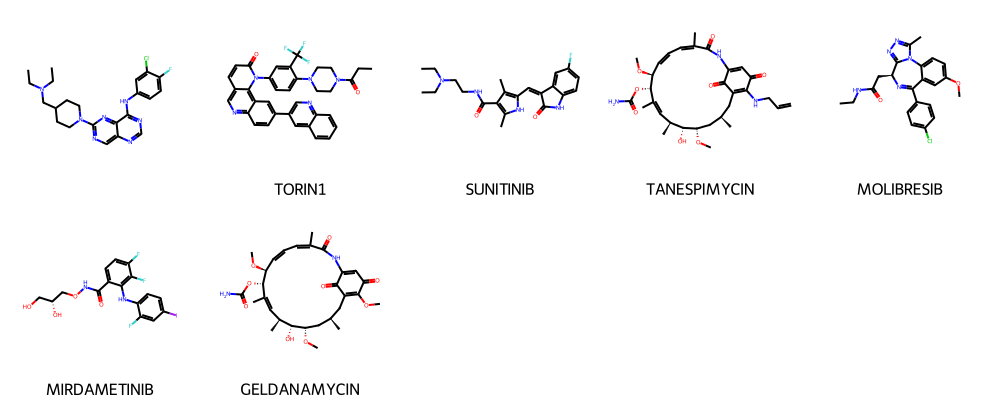

In [61]:
legends = [name if name is not None else '' for name in dfg['pref_name'].tolist()]

Draw.MolsToGridImage(
    dfg['ROMol'].iloc[:20].tolist(),
    legends=legends,
    molsPerRow=5,
    subImgSize=(200, 200)
)

Description of the identified Compounds and their potential relevance in Hepatitis
1. Mirdametinib (PD-0325901): Mirdametinib blocks the MAPK/ERK pathway, a signaling axis involved in cell growth, inflammation, and survival. Although not a direct antiviral, MEK inhibition can interfere with host cellular machinery exploited by viruses, and may help dampen pro-inflammatory signaling in hepatocytes. It has potential for use in combination strategies for viral or inflammatory liver diseases.

2. Sunitinib: inhibits angiogenesis and cell proliferation, pathways frequently activated in chronic liver disease and hepatocellular carcinoma (HCC). While it is not antiviral, its effects may be beneficial in limiting fibrosis progression and liver tumor growth associated with chronic hepatitis.

3. Torin-1: suppresses anabolic signaling and modulates autophagy, a process hijacked by many hepatotropic viruses to facilitate replication. It also reduces inflammatory cytokine production. These features make it an interesting candidate for experimental antiviral or immunomodulatory interventions in hepatitis research.

4. Molibresib (I-BET-762): inhibits BET proteins involved in transcription of inflammatory and viral response genes. In hepatitis models, BET inhibition has demonstrated both antiviral and anti-inflammatory activity by suppressing cytokine overexpression. It has shown efficacy in preclinical models of hepatitis B and C.

5. Tanespimycin (17-AAG):  disrupts the folding of client proteins essential for viral replication and cell stress responses. It has shown promise in reducing hepatitis C viral replication and offers a safer alternative to geldanamycin, with improved pharmacological properties and reduced toxicity.

6. Geldanamycin: was one of the first compounds identified to inhibit HSP90, a chaperone essential for viral protein stability. It impairs viral replication but is limited by its toxicity. Its mechanism has paved the way for second-generation compounds such as tanespimycin, which retain efficacy with improved safety.

These SMILES strings were saved into a file within the generative_molecules/found_drugs.smi directory, alongside the REINVENT generative model configuration. It was decided to simply reference the file location in the notebook rather than include the saving code inline for clarity.

## 2.  Molecule Generation with REINVENT

REINVENT was configured with a reward function in TOML format incorporating key metrics: Tanimoto similarity using Feature-based circular fingerprints (threshold 0.7), QED (0.6), and synthetic accessibility (SA score 0.3). Using staged learning in a single step, the model generated 382 molecules achieving a total reward score of 0.42 with 70% validity, indicating a good balance between chemical plausibility and desired properties.

Generated molecules were filtered to exclude invalid SMILES. The top 100 molecules were selected based on a composite score combining REINVENT’s Score, QED, and normalized SA score. Further filtering was applied to remove reactive or toxic compounds using PAINS filters and to enforce drug-likeness criteria based on Lipinski’s Rule of Five parameters.

The final subset was narrowed to the top 10 molecules ordered by LogP, a commonly used metric for drug-likeness and membrane permeability.



In [69]:
df_drugs= pd.read_csv("generative_mol_1.csv", sep=",", dtype=str, comment='#')
df_drugs

,Agent,Prior,Target,Score,SMILES,SMILES_state,Input_SMILES,Scaffold,Tanimoto vs seeds,Tanimoto vs seeds (raw),QED,QED (raw),SA score,SA score (raw),step
0,24.0882,24.0882,1.4280,0.3189527,CC1=C[C@H](O)[C@H](/C=C\C[C@H](OC(N)=O)/C(C)=C...,1,C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,C1=COCC1,0.0838710,0.0839,0.3695330,0.3695,5.3638104,5.3638,1
1,22.3924,22.3924,6.2691,0.3582683,CC1=C(C[C@@H](C)[C@H](O)[C@@H](C)/C=C(\C)C2=C[...,1,C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,O=C1C=C(CCCCC=CC2=CCCCC2)CCCC/C=C/1,0.0955414,0.0955,0.4142621,0.4143,5.8539303,5.8539,1
2,27.1227,27.1227,-27.1227,0.0000000,C/C(=C\[C@H](C)[C@@H](O)[C@H](C)C[C@H]1C[C@@H]...,0,C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,NaN,0.0000000,0.0000,0.0000000,0.0000,0.0000000,0.0000,1
3,21.5368,21.5368,-21.5368,0.0000000,C/C(=C\[C@H](C)[C@@H](O)[C@H](O)CC1=C(\C)C(=O)...,0,C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,NaN,0.0000000,0.0000,0.0000000,0.0000,0.0000000,0.0000,1
4,22.5781,22.5781,7.3861,0.3745531,CC(=O)N/C(C)=C/[C@H](C)[C@H](O)/C=C/C(C)(C)CC1...,1,C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,O=C1C=C/C=C/CCCC1,0.0993377,0.0993,0.4614171,0.4614,5.4611495,5.4611,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,4.3254,4.3254,25.1834,0.3688598,O=c1ccc2cnc3ccc(-c4cnc5ccccc5c4)cc3c2n1-c1ccc2...,1,CCC(=O)N1CCN(c2ccc(-n3c(=O)ccc4cnc5ccc(-c6cnc7...,O=c1ccc2cnc3ccc(-c4cnc5ccccc5c4)cc3c2n1-c1ccc2...,0.1812500,0.1812,0.3202111,0.3202,2.5688506,2.5689,1
378,3.4341,3.4341,26.6402,0.3759294,O=c1ccc2cnc3ccc(-c4cnc5ccccc5c4)cc3c2n1-c1ccc2...,1,CCC(=O)N1CCN(c2ccc(-n3c(=O)ccc4cnc5ccc(-c6cnc7...,O=c1ccc2cnc3ccc(-c4cnc5ccccc5c4)cc3c2n1-c1ccc2...,0.1847134,0.1847,0.3315498,0.3315,2.5369202,2.5369,1
379,9.4442,9.4442,30.9563,0.5050061,OCC1CCN(c2nccc3ncnc(Nc4ccc(F)c(Cl)c4)c23)CC1,1,CCN(CC)CC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2...,c1ccc(Nc2ncnc3ccnc(N4CCCCC4)c23)cc1,0.1897810,0.1898,0.7094783,0.7095,2.5106195,2.5106,1
380,10.2504,10.2504,29.5539,0.4975543,OCCN1CCN(c2ncc3ncnc(Oc4ccc(F)c(Cl)c4)c3n2)CC1,1,CCN(CC)CC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2...,c1ccc(Oc2ncnc3cnc(N4CCNCC4)nc23)cc1,0.1857143,0.1857,0.6915312,0.6915,2.5677546,2.5678,1


### a. Filter invalid molecules

In [70]:
def smiles_to_mol(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol
    except:
        return None

In [71]:
print(df_drugs.columns)

Index(['Agent', 'Prior', 'Target', 'Score', 'SMILES', 'SMILES_state',
       'Input_SMILES', 'Scaffold', 'Tanimoto vs seeds',
       'Tanimoto vs seeds (raw)', 'QED', 'QED (raw)', 'SA score',
       'SA score (raw)', 'step'],
      dtype='object')


In [73]:
# Invalid Molecules
df_drugs['Mol'] = df_drugs['SMILES'].apply(Chem.MolFromSmiles)
df_drugs = df_drugs[df_drugs['Mol'].notna()].copy()
df_drugs

[18:55:14] SMILES Parse Error: unclosed ring for input: 'C/C(=C\[C@H](C)[C@@H](O)[C@H](C)C[C@H]1C[C@@H]2C(=O)N(CCN(C)C)C=C2C[C@@H](C)[C@H](O)[C@H](O)[C@]2(C)CO1)C(N)=O'
[18:55:14] SMILES Parse Error: extra open parentheses for input: 'C/C(=C\[C@H](C)[C@@H](O)[C@H](O)CC1=C(\C)C(=O)NCCOC1=C\C1=NCC=C1'
[18:55:14] SMILES Parse Error: extra open parentheses for input: 'C/C(=C\[C@H](C)[C@H](O)/C=C/C(C)(C)CC1=C(\F)C(=O)NC=C1C[C@@H](C)C[C@H](C)C[C@]1(C)CO'
[18:55:14] SMILES Parse Error: extra open parentheses for input: 'C/C(=C\[C@H](C)[C@H](O)[C@H](C)CC1=C(C)C/C(=C\C(C)(C)O)C(=O)[C@H]1O'
[18:55:14] SMILES Parse Error: extra open parentheses for input: 'C/C(=C\[C@H](C)[C@H](O)[C@H](C)CC1=C(\F)[C@@H](O)/C=C/C=C(\C)[C@H](O)[C@H](C)CC1=O'
[18:55:14] SMILES Parse Error: unclosed ring for input: 'C/C(=C\[C@H](O)/C=C/C=C\C(C)[C@H](OC(N)=O)[C@H]1C[C@@H]2CCC=C2C(=O)NC1=O)[C@@H](O)[C@@H](O)CCC1'
[18:55:14] Explicit valence for atom # 25 N, 4, is greater than permitted
[18:55:15] SMILES Parse Error: ext

,Agent,Prior,Target,Score,SMILES,SMILES_state,Input_SMILES,Scaffold,Tanimoto vs seeds,Tanimoto vs seeds (raw),QED,QED (raw),SA score,SA score (raw),step,Mol
0,24.0882,24.0882,1.4280,0.3189527,CC1=C[C@H](O)[C@H](/C=C\C[C@H](OC(N)=O)/C(C)=C...,1,C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,C1=COCC1,0.0838710,0.0839,0.3695330,0.3695,5.3638104,5.3638,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870ad7e0>
1,22.3924,22.3924,6.2691,0.3582683,CC1=C(C[C@@H](C)[C@H](O)[C@@H](C)/C=C(\C)C2=C[...,1,C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,O=C1C=C(CCCCC=CC2=CCCCC2)CCCC/C=C/1,0.0955414,0.0955,0.4142621,0.4143,5.8539303,5.8539,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870ad850>
4,22.5781,22.5781,7.3861,0.3745531,CC(=O)N/C(C)=C/[C@H](C)[C@H](O)/C=C/C(C)(C)CC1...,1,C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,O=C1C=C/C=C/CCCC1,0.0993377,0.0993,0.4614171,0.4614,5.4611495,5.4611,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870ae570>
6,21.9323,21.9323,4.9602,0.3361563,C/C1=C\[C@H](C)[C@H](O)/C=C\C(=C(\C)C[C@@H](C)...,1,C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,O=C1C=CCC/C=C\C1=CCCCCCC/C=C\CNCc1ccccc1,0.1437500,0.1437,0.2359911,0.2360,4.9508246,4.9508,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870ae500>
7,31.1414,31.1414,-10.3555,0.2598242,C/C1=C(\C=C[C@@H](O)[C@@H](C)/C=C(\C)[C@@H](OC...,1,C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,O=C1CC[C@@H](/C=C\C=C\CCC=CCCC=CC2=CCCCCSC2=O)N1,0.0742857,0.0743,0.2402899,0.2403,5.6412380,5.6412,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870aeab0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,4.3254,4.3254,25.1834,0.3688598,O=c1ccc2cnc3ccc(-c4cnc5ccccc5c4)cc3c2n1-c1ccc2...,1,CCC(=O)N1CCN(c2ccc(-n3c(=O)ccc4cnc5ccc(-c6cnc7...,O=c1ccc2cnc3ccc(-c4cnc5ccccc5c4)cc3c2n1-c1ccc2...,0.1812500,0.1812,0.3202111,0.3202,2.5688506,2.5689,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec5310>
378,3.4341,3.4341,26.6402,0.3759294,O=c1ccc2cnc3ccc(-c4cnc5ccccc5c4)cc3c2n1-c1ccc2...,1,CCC(=O)N1CCN(c2ccc(-n3c(=O)ccc4cnc5ccc(-c6cnc7...,O=c1ccc2cnc3ccc(-c4cnc5ccccc5c4)cc3c2n1-c1ccc2...,0.1847134,0.1847,0.3315498,0.3315,2.5369202,2.5369,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec5380>
379,9.4442,9.4442,30.9563,0.5050061,OCC1CCN(c2nccc3ncnc(Nc4ccc(F)c(Cl)c4)c23)CC1,1,CCN(CC)CC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2...,c1ccc(Nc2ncnc3ccnc(N4CCCCC4)c23)cc1,0.1897810,0.1898,0.7094783,0.7095,2.5106195,2.5106,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec53f0>
380,10.2504,10.2504,29.5539,0.4975543,OCCN1CCN(c2ncc3ncnc(Oc4ccc(F)c(Cl)c4)c3n2)CC1,1,CCN(CC)CC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2...,c1ccc(Oc2ncnc3cnc(N4CCNCC4)nc23)cc1,0.1857143,0.1857,0.6915312,0.6915,2.5677546,2.5678,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec5460>


In [75]:
print("SMILES válidos:", len(df_drugs))

SMILES válidos: 282


### b. Filter of 100 molecules based on Score, QED , Synthetic Accessibility

In [76]:
df_drugs['SA_norm'] = 10 - df_drugs['SA score'].astype(float)

df_drugs['combo_score'] = (
    0.5 * df_drugs['Score'].astype(float) +
    0.6 * df_drugs['QED'].astype(float) +
    0.4 * df_drugs['SA_norm']
)

df_top = df_drugs.sort_values('combo_score', ascending=False).head(100)
df_top

,Agent,Prior,Target,Score,SMILES,SMILES_state,Input_SMILES,Scaffold,Tanimoto vs seeds,Tanimoto vs seeds (raw),QED,QED (raw),SA score,SA score (raw),step,Mol,SA_norm,combo_score
358,14.5328,14.5328,25.8207,0.5044193,O=C(O)c1ccc(F)c(F)c1Nc1ccc(F)cc1F,1,O=C(NOC[C@H](O)CO)c1ccc(F)c(F)c1Nc1ccc(I)cc1F,c1ccc(Nc2ccccc2)cc1,0.1779661,0.1780,0.8455888,0.8456,2.0407209,2.0407,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec4ac0>,7.959279,3.943275
134,9.1424,9.1424,27.7599,0.4612778,CN1CCN(c2ncc3ncnc(Nc4ccccc4)c3n2)CC1,1,CCN(CC)CC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2...,c1ccc(Nc2ncnc3cnc(N4CCNCC4)nc23)cc1,0.1470588,0.1471,0.7899590,0.7900,2.2652278,2.2652,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870afdf0>,7.734772,3.798523
328,5.3492,5.3492,36.0784,0.5178454,NC(=O)c1ccc(F)c(F)c1Nc1ccc(I)cc1Cl,1,O=C(NOC[C@H](O)CO)c1ccc(F)c(F)c1Nc1ccc(I)cc1F,c1ccc(Nc2ccccc2)cc1,0.1982759,0.1983,0.7526030,0.7526,2.3030645,2.3031,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec3d10>,7.696936,3.789259
254,8.2955,8.2955,70.8730,0.9896073,COc1ccc2c(c1)C(c1ccc(Cl)cc1)=N[C@@H](CO)c1nnc(...,1,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...,c1ccc(C2=NCc3nncn3-c3ccccc32)cc1,0.7666667,0.7667,0.7705168,0.7705,2.9613459,2.9613,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec1d20>,7.038654,3.772575
319,5.4395,5.4395,33.6424,0.4885229,Fc1ccc(Nc2ncnc3cnc(N4CCCC4)nc23)cc1Cl,1,CCN(CC)CC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2...,c1ccc(Nc2ncnc3cnc(N4CCCC4)nc23)cc1,0.1654135,0.1654,0.7833160,0.7833,2.3778256,2.3778,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec3920>,7.622174,3.763121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,9.9960,9.9960,32.2500,0.5280739,CCN(CC)CCNC(=O)c1c(C)[nH]c2c1CC/C2=C1\C(=O)Nc2...,1,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,O=C1Nc2ccccc2/C1=C1/CCc2cc[nH]c21,0.2246377,0.2246,0.6136603,0.6137,2.8733570,2.8734,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870aeea0>,7.126643,3.482890
154,7.3084,7.3084,26.2580,0.4195799,COC(=O)c1ccc2cnc3ccc(-c4cnc5ccccc5c4)cc3c2n1,1,CCC(=O)N1CCN(c2ccc(-n3c(=O)ccc4cnc5ccc(-c6cnc7...,c1ccc2ncc(-c3ccc4ncc5cccnc5c4c3)cc2c1,0.2462687,0.2463,0.3325151,0.3325,2.3161559,2.3162,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec06d0>,7.683844,3.482837
226,4.4015,4.4015,54.9524,0.7419240,COc1ccc2c(c1)C(c1ccc(Cl)cc1)=NC(Cc1ccccc1)c1nn...,1,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...,c1ccc(CC2N=C(c3ccccc3)c3ccccc3-n3cnnc32)cc1,0.6509434,0.6509,0.4385963,0.4386,2.8808422,2.8808,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec10e0>,7.119158,3.481783
208,6.2785,6.2785,30.1684,0.4555865,COCCOCC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1,1,CCN(CC)CC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2...,c1ccc(Nc2ncnc3cnc(N4CCCCC4)nc23)cc1,0.1904762,0.1905,0.5223149,0.5223,2.6518668,2.6519,1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec0a50>,7.348133,3.480435


In [77]:
df_top2 = df_top[['SMILES','Mol']].dropna().drop_duplicates()
df_top2

,SMILES,Mol
358,O=C(O)c1ccc(F)c(F)c1Nc1ccc(F)cc1F,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec4ac0>
134,CN1CCN(c2ncc3ncnc(Nc4ccccc4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870afdf0>
328,NC(=O)c1ccc(F)c(F)c1Nc1ccc(I)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec3d10>
254,COc1ccc2c(c1)C(c1ccc(Cl)cc1)=N[C@@H](CO)c1nnc(...,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec1d20>
319,Fc1ccc(Nc2ncnc3cnc(N4CCCC4)nc23)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec3920>
...,...,...
97,CCN(CC)CCNC(=O)c1c(C)[nH]c2c1CC/C2=C1\C(=O)Nc2...,<rdkit.Chem.rdchem.Mol object at 0x7d4c870aeea0>
154,COC(=O)c1ccc2cnc3ccc(-c4cnc5ccccc5c4)cc3c2n1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec06d0>
226,COc1ccc2c(c1)C(c1ccc(Cl)cc1)=NC(Cc1ccccc1)c1nn...,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec10e0>
208,COCCOCC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec0a50>


### c. Filter by Drug-Likeness

In [78]:
def drug_likness_decriptors(df_top2):

    pd.options.mode.chained_assignment = None

    NumHDonors_list = []
    NumHAcceptors_list = []
    MW_list = []
    LogP_list = []
    rotatable_bonds_list = []

    for element in df_top2['Mol']:
        try:
            NumHDonors = Descriptors.NumHDonors(element)
            NumHDonors_list.append(NumHDonors)
        except:
            NumHDonors_list.append('N/A')
            pass

        try:
            NumHAcceptors = Descriptors.NumHAcceptors(element)
            NumHAcceptors_list.append(NumHAcceptors)
        except:
            NumHAcceptors_list.append('N/A')
            pass

        try:
            # Calcular el peso molecular exacto
            MW = Descriptors.ExactMolWt(element)
            MW_list.append(MW)
        except:
            MW_list.append('N/A')
            pass

        try:
            # Calcular el logP
            LogP = Descriptors.MolLogP(element)
            LogP_list.append(LogP)
        except:
            LogP_list.append('N/A')
            pass

        try:
            rotatable_bonds = Descriptors.NumRotatableBonds(element)
            rotatable_bonds_list.append(rotatable_bonds)
        except:
            rotatable_bonds_list.append('N/A')
            pass

    df_top2['HBD'] = NumHDonors_list
    df_top2['HBA'] = NumHAcceptors_list
    df_top2['MW'] = MW_list
    df_top2['logP'] = LogP_list
    df_top2['nRotB'] = rotatable_bonds_list

    return df_top2

In [79]:
df_with_props = drug_likness_decriptors(df_top2)
df_with_props

,SMILES,Mol,HBD,HBA,MW,logP,nRotB
358,O=C(O)c1ccc(F)c(F)c1Nc1ccc(F)cc1F,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec4ac0>,2,2,285.041291,3.68480,3
134,CN1CCN(c2ncc3ncnc(Nc4ccccc4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870afdf0>,1,7,321.170194,1.91520,3
328,NC(=O)c1ccc(F)c(F)c1Nc1ccc(I)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec3d10>,2,2,407.933795,4.06530,3
254,COc1ccc2c(c1)C(c1ccc(Cl)cc1)=N[C@@H](CO)c1nnc(...,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec1d20>,1,6,368.104003,3.12212,3
319,Fc1ccc(Nc2ncnc3cnc(N4CCCC4)nc23)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec3920>,1,6,344.095250,3.55610,3
...,...,...,...,...,...,...,...
97,CCN(CC)CCNC(=O)c1c(C)[nH]c2c1CC/C2=C1\C(=O)Nc2...,<rdkit.Chem.rdchem.Mol object at 0x7d4c870aeea0>,3,3,426.182254,3.85722,6
154,COC(=O)c1ccc2cnc3ccc(-c4cnc5ccccc5c4)cc3c2n1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec06d0>,0,5,365.116427,4.78480,2
226,COc1ccc2c(c1)C(c1ccc(Cl)cc1)=NC(Cc1ccccc1)c1nn...,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec10e0>,0,5,428.140389,5.37252,4
208,COCCOCC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec0a50>,1,8,446.163330,3.83530,8


In [80]:
def filter_lipinski(df_with_props):
    filtered = df_with_props[
        (df_top2['HBD'] <= 5) &
        (df_top2['HBA'] <= 10) &
        (df_top2['MW'] <= 500) &
        (df_top2['logP'] <= 5)
    ]
    return filtered

df_filtered = filter_lipinski(df_with_props)
df_filtered

,SMILES,Mol,HBD,HBA,MW,logP,nRotB
358,O=C(O)c1ccc(F)c(F)c1Nc1ccc(F)cc1F,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec4ac0>,2,2,285.041291,3.68480,3
134,CN1CCN(c2ncc3ncnc(Nc4ccccc4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870afdf0>,1,7,321.170194,1.91520,3
328,NC(=O)c1ccc(F)c(F)c1Nc1ccc(I)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec3d10>,2,2,407.933795,4.06530,3
254,COc1ccc2c(c1)C(c1ccc(Cl)cc1)=N[C@@H](CO)c1nnc(...,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec1d20>,1,6,368.104003,3.12212,3
319,Fc1ccc(Nc2ncnc3cnc(N4CCCC4)nc23)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec3920>,1,6,344.095250,3.55610,3
...,...,...,...,...,...,...,...
221,COc1ccc(C2=N[C@H](C(=O)Nc3ccccc3)c3nnc(C)n3-c3...,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec0eb0>,1,6,437.185175,4.42354,4
97,CCN(CC)CCNC(=O)c1c(C)[nH]c2c1CC/C2=C1\C(=O)Nc2...,<rdkit.Chem.rdchem.Mol object at 0x7d4c870aeea0>,3,3,426.182254,3.85722,6
154,COC(=O)c1ccc2cnc3ccc(-c4cnc5ccccc5c4)cc3c2n1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec06d0>,0,5,365.116427,4.78480,2
208,COCCOCC1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec0a50>,1,8,446.163330,3.83530,8


### d. Remove reactive/toxic compounds

In [81]:
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog.FilterCatalog(params)

def is_reactive_or_toxic(mol):
    entry = catalog.GetFirstMatch(mol)
    return entry is not None

df_filtered['is_reactive_or_toxic'] = df_filtered['Mol'].apply(is_reactive_or_toxic)
df_filtered_clean = df_filtered[~df_filtered['is_reactive_or_toxic']].copy()

print(f"Removed {df_filtered['is_reactive_or_toxic'].sum()} reactive/toxic compounds")

Removed 0 reactive/toxic compounds


In [82]:
top10 = df_filtered.sort_values(by='logP').head(10)
top10

,SMILES,Mol,HBD,HBA,MW,logP,nRotB,is_reactive_or_toxic
264,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(F)cc32)c(C)c1C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec2110>,4,3,356.128469,1.47844,4,False
137,CNCC(=O)N1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2...,<rdkit.Chem.rdchem.Mol object at 0x7d4c870afed0>,2,8,430.143263,1.82390,5,False
268,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(F)cc32)c(C)c1C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec22d0>,4,4,411.207053,1.89834,5,False
134,CN1CCN(c2ncc3ncnc(Nc4ccccc4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870afdf0>,1,7,321.170194,1.91520,3,False
332,NCN1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec3ed0>,2,8,388.132698,1.99410,4,False
380,OCCN1CCN(c2ncc3ncnc(Oc4ccc(F)c(Cl)c4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec5460>,1,8,404.116380,2.11890,5,False
364,O=CN1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec4d60>,1,7,387.101064,2.23430,4,False
271,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(F)cc32)c(C)c1C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec2420>,3,5,394.155352,2.28484,5,False
320,Fc1ccc(Nc2ncnc3cnc(N4CCNCC4)nc23)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec3990>,2,7,359.106149,2.36550,3,False
258,CS(=O)(=O)CCNc1ncc2ncnc(Nc3ccc(F)c(Cl)c3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec1ee0>,2,8,396.057151,2.41240,6,False


In [83]:
top10.to_csv("druglike_molecules.csv", index=False)

### e. Visualize Top 10 Molecules

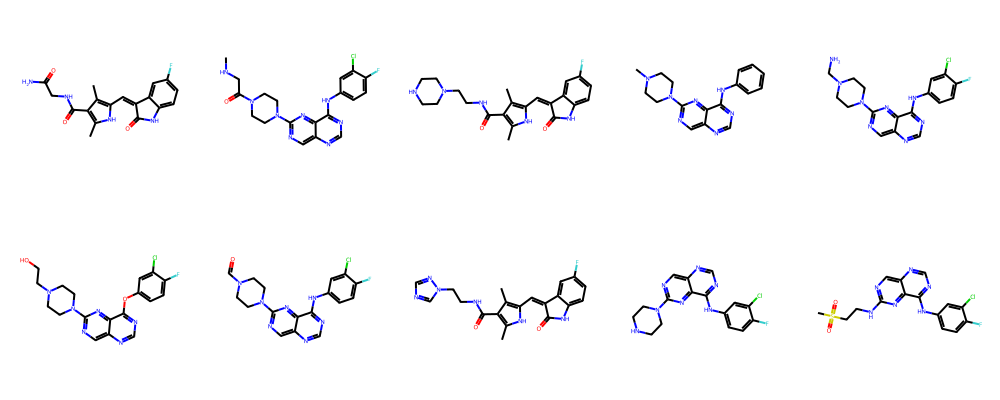

In [84]:
top10["Mol"] = top10["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))

Draw.MolsToGridImage(
    top10['Mol'].iloc[:20].tolist(),
    molsPerRow=5,
    subImgSize=(200, 200)
)

## Structural Novelty

To assess novelty, the filtered molecules were compared against FDA-approved drugs and ChEMBL stage 4 approved drugs. Due to dataset size, ChEMBL data was accessed via API and filtered for advanced-stage compounds.

Using Morgan fingerprints and Tanimoto similarity, the maximum similarity scores of generated molecules to known drugs were calculated. Similarities averaged around 0.3, suggesting a high degree of structural novelty. However, similarity to FDA-approved drugs may not perfectly correlate with functional or regulatory relevance.

### FDA-approved Drugs

In [85]:
df_generated = pd.read_csv("druglike_molecules.csv")
df_fda = pd.read_csv("FDA_Drugs.csv")

In [86]:
gen_mols = [Chem.MolFromSmiles(smi) for smi in df_generated['SMILES']]
fda_mols = [Chem.MolFromSmiles(smi) for smi in df_fda['SMILES']]

gen_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in gen_mols]
fda_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in fda_mols]

max_tanimotos = []
for gen_fp in gen_fps:
    scores = [TanimotoSimilarity(gen_fp, fda_fp) for fda_fp in fda_fps]
    max_tanimotos.append(max(scores))

df_generated['max_tanimoto_vs_fda'] = max_tanimotos
df_novel = df_generated[df_generated['max_tanimoto_vs_fda'] < 0.4]


In [87]:
df_novel

,SMILES,Mol,HBD,HBA,MW,logP,nRotB,is_reactive_or_toxic,max_tanimoto_vs_fda
3,CN1CCN(c2ncc3ncnc(Nc4ccccc4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870afdf0>,1,7,321.170194,1.9152,3,False,0.274510
5,OCCN1CCN(c2ncc3ncnc(Oc4ccc(F)c(Cl)c4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec5460>,1,8,404.116380,2.1189,5,False,0.306818
6,O=CN1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec4d60>,1,7,387.101064,2.2343,4,False,0.379310
8,Fc1ccc(Nc2ncnc3cnc(N4CCNCC4)nc23)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec3990>,2,7,359.106149,2.3655,3,False,0.392405
9,CS(=O)(=O)CCNc1ncc2ncnc(Nc3ccc(F)c(Cl)c3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec1ee0>,2,8,396.057151,2.4124,6,False,0.388889


### CHEMBL stage4 aproved drugs

In [88]:
molecule = new_client.molecule

approved = molecule.filter(max_phase=4)

approved_list = []

for mol in approved:
    try:
        smi = mol['molecule_structures']['canonical_smiles']
        chembl_id = mol['molecule_chembl_id']
        name = mol['pref_name']
        approved_list.append({'chembl_id': chembl_id, 'smiles': smi, 'name': name})
    except:
        continue

df_approved = pd.DataFrame(approved_list)
df_approved.to_csv('chembl_approved_drugs.csv', index=False)


In [89]:
df_gen = pd.read_csv("druglike_molecules.csv")
df_chembl = pd.read_csv("chembl_approved_drugs.csv")

In [90]:
gen_mols = [Chem.MolFromSmiles(smi) for smi in df_generated['SMILES']]
chembl_mols = [Chem.MolFromSmiles(smi) for smi in df_chembl['smiles']]

gen_mols = [mol for mol in gen_mols if mol is not None]
chembl_mols = [mol for mol in chembl_mols if mol is not None]

gen_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in gen_mols]
chembl_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in chembl_mols]


max_tanimotos = []
for gen_fp in gen_fps:
    scores = [TanimotoSimilarity(gen_fp, chembl_fp) for chembl_fp in chembl_fps]
    max_tanimotos.append(max(scores))

df_generated.loc[df_generated['SMILES'].apply(lambda x: Chem.MolFromSmiles(x) is not None), 'max_tanimoto_vs_chembl_approved'] = max_tanimotos

df_nov = df_generated[df_generated['max_tanimoto_vs_chembl_approved'] < 0.4]

[19:03:23] WARNING: not removing hydrogen atom without neighbors
[19:03:23] WARNING: not removing hydrogen atom without neighbors
[19:03:23] WARNING: not removing hydrogen atom without neighbors
[19:03:23] WARNING: not removing hydrogen atom without neighbors
[19:03:23] WARNING: not removing hydrogen atom without neighbors
[19:03:23] WARNING: not removing hydrogen atom without neighbors


In [91]:
df_nov

,SMILES,Mol,HBD,HBA,MW,logP,nRotB,is_reactive_or_toxic,max_tanimoto_vs_fda,max_tanimoto_vs_chembl_approved
3,CN1CCN(c2ncc3ncnc(Nc4ccccc4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c870afdf0>,1,7,321.170194,1.9152,3,False,0.274510,0.274510
5,OCCN1CCN(c2ncc3ncnc(Oc4ccc(F)c(Cl)c4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec5460>,1,8,404.116380,2.1189,5,False,0.306818,0.306818
6,O=CN1CCN(c2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec4d60>,1,7,387.101064,2.2343,4,False,0.379310,0.379310
8,Fc1ccc(Nc2ncnc3cnc(N4CCNCC4)nc23)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec3990>,2,7,359.106149,2.3655,3,False,0.392405,0.392405
9,CS(=O)(=O)CCNc1ncc2ncnc(Nc3ccc(F)c(Cl)c3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7d4c86ec1ee0>,2,8,396.057151,2.4124,6,False,0.388889,0.388889


## Final Conclussions

Throughout the workflow, key observations were made. The predominance of up-regulated genes and the need for lowered fold change thresholds indicated subtle transcriptional differences between infected and control samples. The incomplete gene mapping in CLUE.io likely limited drug discovery power, with few candidates related to hepatitis emerging.

The generative model produced chemically valid and drug-like molecules with promising novelty profiles after filtering, but experimental validation remains essential. Overall, the pipeline demonstrated a comprehensive integration of transcriptomic analysis, connectivity mapping, cheminformatics, and molecular generation for drug discovery.